# 15.5 Word Embedding with Global Vectors (GloVe)

Word-word co-occurrences within context windows may carry rich semantic information. For example, in a large corpus word “solid” is more likely to co-occur with “ice” than “steam”, but word “gas” probably co-occurs with “steam” more frequently than “ice”. Besides, global corpus statistics of such co-occurrences can be precomputed: this can lead to more efficient training. To leverage statistical information in the entire corpus for word embedding, let’s first revisit the skip-gram model in Section 15.1.3, but interpreting it using global corpus statistics such as co-occurrence counts.

## 15.5.1 Skip-Gram with Global Corpus Statistics

Let us denote $q_{ij}$ as follow:

$$

q_{ij} = \cfrac{exp(\mathbf{u_j}^T \mathbf{v_i})}{\sum_{k \in \mathcal{V}} exp(\mathbf{u_k}^T \mathbf{v_i})}

$$

Consider word $w_i$ that may occur multiple times in the corpus. In the entire corpus, all the context words wherever $w_i$ is taken as their centerword form a mutiset $\mathcal{C}_i$ of word indices. For any element, its number of instances is called its $multiplicity.

Now, let's denote the multiplicity of element $j$ in multicet $C_i$ as $x_{ij}$. This is the global occurence count of word $w_j$ and word $w_i$ in the same context window in the entire corpus. Using such global corpus statistics, the loss function of the skip-gram model is equivalent to 


$$

- \sum_{i \in \mathcal{V}} \sum_{j \in \mathcal{V}} x_{ij} log q_{ij}

$$

We further denote by $x_i$ the number of all the context words in the context windows where $w_i$ occurs as their center word, this is equivalent to $|C_i|$. Letting $p_{ij}$ be the conditional probability $x_{ij} / x_i$ for generating context word $w_j$ given center word $w_i$.

$$

- \sum_{i \in \mathcal{V}} x_i \sum_{j \in \mathcal{V}} p_{ij} log q_{ij}

$$


Here, $- \sum_{j \in \mathcal{V}} p_{ij} log q_{ij}$ calculates the CE of the conditional distribution $p_{ij}$ of global corpus statistics and the conditional distribution $q_{ij}$ of model predictions. This loss is also weighted by $x_i$ as explained above.

Though being commonly used for measuring the distance between probability distributions, the CE loss function may not be a good choice here. 

 - The cost of properly normalizing $q_{ij}$ results in the sum over the entire vocab, which can be computationally expensive.
 - Large number of rare events from a large corpus are often modeled by the cross-entropy loss to be assigned with too much weight.

 ## 15.5.2 The GloVe Model

 In view of this, the GloVe model makes three changes to the skip-gram model based on squared loss:

 - Use variables $p_{ij}' = x_{ij}$ and $q_{ij}' = exp(\mathbf{u_j}^T \mathbf{v_i})$ that are not probability distributions and take the logarithm of both, so the squared loss term is $\left( log p_{ij}' - log q_{ij}' \right)^2 = \left( \mathbf{u_j}^T \mathbf{v_i} - log x_{ij}\right)^2$

 - Add two scalar model parameters for each word $w_i$: the center word bias $b_i$ and the context word bias $c_i$.

 - Replace the weight of each loss term with the weight function $h(x_{ij})$, where $h(x)$ is increasing in the interval of $[0, 1]$

 Putting all things together, training GloVe is to minimize the following loss function:

 $$
 
 \sum_{i \in \mathcal{V}} \sum_{j \in \mathcal{V}} h(x_{ij}) \left(\mathbf{u_j}^T \mathbf{v_i} + b_i + c_j - log x_{ij} \right)^2


 $$


 For the weight function, a suggested choice is $h(x) = (x/c)^\alpha$. 
 In this case, because $h(0) = 0$, the squared loss term for any $x_ij = 0$ can be omitted for computational efficiency.

 It should be emphasized that if word $w_i$ appears in the context window of word $w_j$, then vice versa. Therefore, $x_{ij} = x_{ji}$. Unlike word2vec that fits the asymmetric conditional probability $p_{ij}$, Glove fits the symmetric $log x_{ij}$. Therefore, the center word vector and the context word vector of any word are mathematically equivalent in the GloVe model. 

## 15.5.3 Interpreting GloVe from the Ratio of Co-occurrence Probabilities

We can also interpret the GloVe model from another perspectiv. Using the same notation in Section 15.5.1, let $p_{ij} = P(w_j | w_i)$ be the conditional probability of generating the context word $w_j$ given $w_i$ as the center word in the corpus. The following table lists several co-occurrence probabilities given words "ice" and "steam" and their ratios based on statistics from a large corpus.

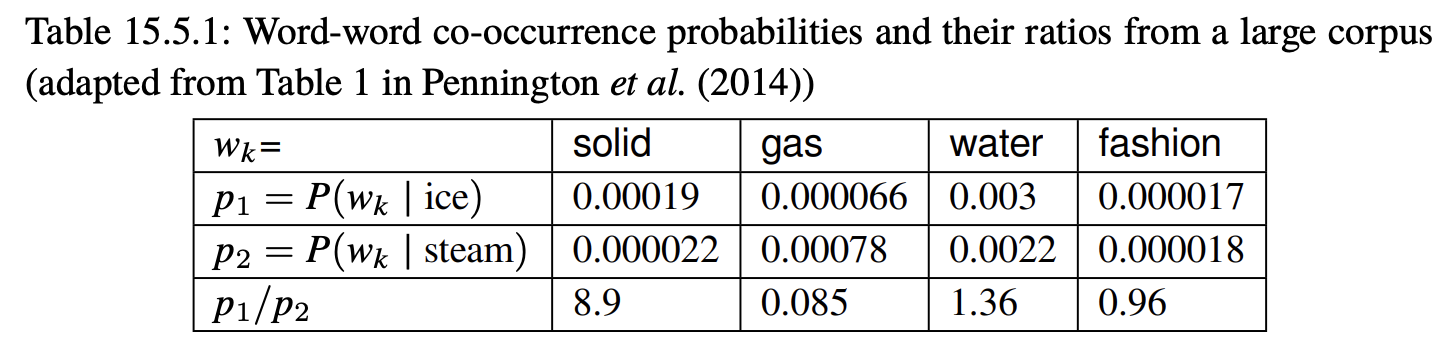

We can observe the following:


 - For a word $w_k$ that is related to "ice" but unrelated to "steam", such as $w_k = solid$, we expect a larger ratio of co-occurence probabilities, such as 8.9.

 - For a word $w_k$ that is related to "steam" but unrelated to "ice", such as $w_k = gas$, we expect a smaller ratio of co-occurence probabilities, such as 0.085.

 - For a word $w_k$ that is related to both "ice" and "steam", such as $w_k = water$, we expect a ratio of co-occurence probabilities that is close to 1, such as 1.36.

 - For a word $w_k$ that is unrelated to both "ice" and "steam", such as $w_k = fashioin$, we expect a ratio of co-occurence probabilities that is close to 1, such as 0.96.


It can be seen that the ratio of co-occurrence probabilities can intuitively express the relationship between words. Thus, we can design a function of three word vectors to fit this ratio. For the ratio of co-occurrence probabilities $p_{ij} / p_{ik}$ with $w_i$ being center word and $w_j$ and $w_k$ being the context words, we want to fit this ratio using some function $f$:

$$

f(\mathbf{u_j}, \mathbf{u_k}, \mathbf{v_i}) \simeq \cfrac{p_{ij}}{p_{ik}}

$$

Now let's pick $exp(\mathbf{u_j}^T \mathbf{v_i}) \simeq \alpha p_{ij}$, where $\alpha$ is a constant. Since $p_{ij} = x_{ij} / x_i$, after taking the logarithm on both sides we get $ \mathbf{u_j}^T \mathbf{v_i} \simeq \log \alpha \log x_{ij} - \log x_i$. We may use additional bias term to fit $- \log \alpha + \log x_i$, such as the center word bias $b_i$ and the context word bias $c_j$:

$$

\mathbf{u_j}^T \mathbf{v_i} + b_i + c_j \simeq \log x_{ij}

$$


Measuring the squared error of with weights, the GloVe loss function in is obtained.